In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit

In [7]:
choose = input("Wybierz zbiór danych:\n*babar\n*cleo\n*besiii")

Kanał 1. będzie rozpadem $\eta \pi^{\pm}\\$
Kanał 2. będzie rozpadem $K^{\pm}$

In [8]:
def chooseDataSet(choose):
    if choose == "babar":
        data = pd.read_excel("a0980def2.xlsx", sheet_name = "Dataset")
        M_eta_pi = data['Mass'] # M
        events = data['Event']
        error = 0.5*(data['hErr'] - data['lErr'])
        M_etaC = 2.984
        title = "Wykres babar-pieta"
        return M_eta_pi, events, error, M_etaC, title
    elif choose == "cleo":
        data = pd.read_excel("a0980-CLEO.xlsx", sheet_name = "Dataset")
        M_eta_pi = data['Mass'] # M
        events = data['Event']
        error = 0.5*(data['hErr'] - data['lErr'])
        title = "Wykres cleo"
        M_etaC = 2.984
        return M_eta_pi, events, error, M_etaC, title
    elif choose == "besiii":
        data = pd.read_excel("a0980besiii.xlsx", sheet_name = "data")
        M_eta_pi = np.linspace(0.696629213, 1.262640449, 59) # M
        events = data['Events']
        error = data['Error']
        title = "Wykres besiii"
        M_chi_1 = 3.510
        return M_eta_pi, events, error, M_chi_1, title

In [9]:
best_params = (-7.557312339457606,
 -13.764927717019052,
 6.268949878687042,
 -0.10152576024481179,
 -0.030018601855952492,
 -0.016606737825243453,
 0.11520046995286704)
range_width = 0.1

In [10]:
M_eta_pi, events, error, M_decayed, plot_title = chooseDataSet(choose)

M_eta = 0.548
M_pi = 0.14
M_K = 0.493
GR = 0.112

$s = M^{2}$

In [11]:

def k_i(channel, M):
    if channel == 1:
        return np.sqrt(M**2 - (M_pi + M_eta)**2 + 0j)
    elif channel == 2:
        return np.sqrt(M**2 - (2 * M_K)**2 +0j)
    
def lbd(x, y, z):
    return x**2+y**2+z**2-2*(x*y + x*z + y*z)

def phaseSpace(M):
    def p(M):
        return np.sqrt(lbd(M**2, M_decayed**2, M_pi**2))/(2*M_decayed)
    def q(M):
        return np.sqrt(lbd(M**2, M_eta**2, M_pi**2))/(2*M)
    return p(M)*q(M)*M_decayed

def productionTerm(M, p0, p1):
    return p0 + p1*M**2

def backgroundTerm(M, b0, b1):
    return b0 + b1*M**2
    
def backgroundTerm2(M, b1):
    return b1*(M**2 - (M_pi+M_eta)**2)
def T11(M, m11, m22, m12_squared):
    return (m22 - 1j * k_i(2, M)) / ((m11 - 1j * k_i(1, M)) * (m22 - 1j * k_i(2, M)) - m12_squared)

def intensity(M, p0, p1, m11, m22, m12_squared, b0, b1):
    return phaseSpace(M)*(np.power(abs(productionTerm(M, p0, p1)*T11(M, m11, m22, m12_squared)),2) + backgroundTerm(M, b0, b1))

def intensity2(M, p0, p1, m11, m22, m12_squared, b1):
    return phaseSpace(M)*(np.power(abs(productionTerm(M, p0, p1)*T11(M, m11, m22, m12_squared)),2) + backgroundTerm2(M, b1))

def findParams(func, prange, num, xdata, ydata, errors, chi_square, cost_fun, title):
    plt.scatter(xdata, ydata, marker = 'o', c = 'black')
    plt.title(title)
    plt.xlabel(r"$\sqrt{s}$ [GeV]")
    plt.ylabel("Events / bin width [GeV]")
    plt.errorbar(xdata, ydata, errors, c = 'black', linestyle = '')
    good_parameters = np.empty((0, 7))
    error_good_parameters = np.empty((0, 7))
    array_of_good_parameters = []
    errors_array_of_good_parameters = []

    for _ in range(num):
        p0_val = np.random.uniform(*prange['p0'])
        p1_val = np.random.uniform(*prange['p1'])
        m11_val = np.random.uniform(*prange['m11'])
        m22_val = np.random.uniform(*prange['m22'])
        m12_squared_val = np.random.uniform(*prange['m12_squared'])
        b0_val = np.random.uniform(*prange['b0'])
        b1_val = np.random.uniform(*prange['b1'])

        # m1 = Minuit(cost_fun, p0=p0_val, p1=p1_val, m11=m11_val, m22=m22_val,
                    # m12_squared=m12_squared_val, b1=b1_val)
        m1 = Minuit(cost_fun, p0=p0_val, p1=p1_val, m11=m11_val, m22=m22_val,
            m12_squared=m12_squared_val, b0=b0_val, b1=b1_val)
        m1.migrad()

        chi2_manual = np.sum(((ydata - func(xdata, *m1.values)) / errors) ** 2)
        if ((chi2_manual/m1.ndof < chi_square) and (m1.fmin.has_accurate_covar == True)):

            # good_parameters = [p0_val, p1_val, m11_val, m22_val, m12_squared_val, b1_val]
            good_parameters = [p0_val, p1_val, m11_val, m22_val, m12_squared_val, b0_val, b1_val]
            error_good_parameters = m1.errors
            errors_array_of_good_parameters.append(error_good_parameters)
            array_of_good_parameters.append(good_parameters)

            good_parameters = []
            error_good_parameters = []
            # print(f"my chi: {chi2_manual/m1.ndof}\nminuit chi: {m1.fval/m1.ndof}\nratio: {(m1.fval/m1.ndof)/(chi2_manual/m1.ndof)}\n")
            # plt.plot(xdata, func(xdata, m1.values[0], m1.values[1], m1.values[2], m1.values[3], m1.values[4], m1.values[5]), alpha = 0.8)
            plt.plot(xdata, func(xdata, m1.values[0], m1.values[1], m1.values[2], m1.values[3], m1.values[4], m1.values[5], m1.values[6]), alpha = 0.09)
        m1 = None


    return array_of_good_parameters, errors_array_of_good_parameters


def printGoodParams(arrayParams, arrayErrors):
    arrayOfSums = []
    for i in arrayErrors:
        if np.sum(i) != 0:
            arrayOfSums.append(np.sum(i))

    # Znalezienie minimalnej wartości
    min_value = np.min(arrayOfSums)

    # Znalezienie indeksu minimalnej wartości
    min_index = np.argmin(arrayOfSums)

    print("Minimalna wartość:", min_value)
    print("Indeks minimalnej wartości:", min_index)
    print("Parametry: ", arrayParams[min_index])



def makeMinuit2(cost_fun, params):
    m1 = Minuit(cost_fun, params[0], params[1], params[2], params[3], params[4], params[5])
    return m1

def makeMinuit(cost_fun, params):
    m1 = Minuit(cost_fun, params[0], params[1], params[2], params[3], params[4], params[5], params[6])
    return m1

def meanValuesOfErrors(errs):
    m11_err = []
    m22_err = []
    m12_squared_err = []
    for i in range(len(errs) - 1):
        m11_err.append(errs[i][2])
        m22_err.append(errs[i][3])
        m12_squared_err.append(errs[i][4])

    print(f"m11_err_mean: {np.mean(m11_err)}\nm22_err_mean: {np.mean(m22_err)}\nm12_squared_err: {np.mean(m12_squared_err)}")

def meanValuesAllParams(params):
    p0 = []
    p1 = []
    b0 = []
    b1 = []
    m11 = []
    m22 = []
    m12_squared = []
    for i in range(len(params) - 1):
        p0.append(params[i][0])
        p1.append(params[i][1])
        m11.append(params[i][2])
        m22.append(params[i][3])
        m12_squared.append(params[i][4])
        b0.append(params[i][5])
        b1.append(params[i][6])
    print(f"p0_mean: {np.mean(p0)}\np1_mean: {np.mean(p1)}\nb0_mean: {np.mean(b0)}\nb1_mean: {np.mean(b1)}\nm11_mean: {np.mean(m11)}\nm22_mean: {np.mean(m22)}\nm12_squared: {np.mean(m12_squared)}")
    return np.mean(p0), np.mean(p1), np.mean(m11), np.mean(m22), np.mean(m12_squared), np.mean(b0), np.mean(b1)

In [12]:

numberOfLoops = 100

param_ranges2 = {
    'p0': (-8, -7),
    'p1': (-18, -10),
    'm11': (5, 8),
    'm22': (-1, 1),
    'm12_squared': (-0.3, 0.3),
    'b1': (-1, 1)
}

param_ranges = {
    "p0": (best_params[0] * (1 - range_width), best_params[0] * (1 + range_width)),
    "p1": (best_params[1] * (1 - range_width), best_params[1] * (1 + range_width)),
    "m11": (best_params[2] * (1 - range_width), best_params[2] * (1 + range_width)),
    "m22": (best_params[3] * (1 - range_width), best_params[3] * (1 + range_width)),
    "m12_squared": (best_params[4] * (1 - range_width), best_params[4] * (1 + range_width)),
    "b0": (best_params[5] - 0.1, best_params[5] + 0.1),  
    "b1": (best_params[6] - 0.1, best_params[6] + 0.1)
}

costFun = cost.LeastSquares(M_eta_pi, events, error, intensity)

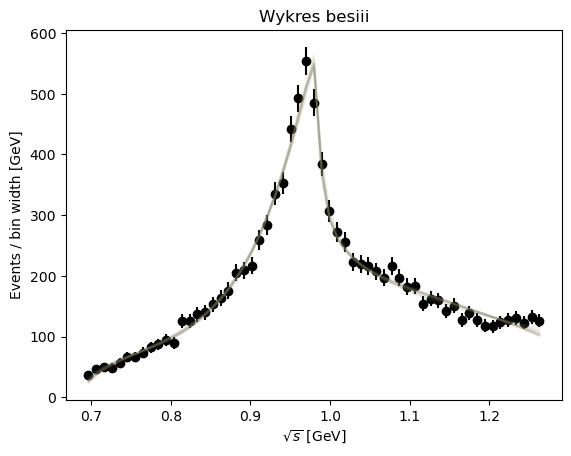

In [16]:
params, err = findParams(intensity, param_ranges, 1000, M_eta_pi, events, error, 1.3, costFun, plot_title)

In [14]:
meanValuesOfErrors(err)
printGoodParams(arrayParams = params, arrayErrors = err)
meanValuesAllParams(params)

m11_err_mean: 0.13671439154251155
m22_err_mean: 0.3074900499477245
m12_squared_err: 2.869181080142831
Minimalna wartość: 19.41133073401369
Indeks minimalnej wartości: 3
Parametry:  [-7.845043860521512, -13.896548095488955, 6.634485013473986, -0.09271239445373118, -0.028525283829297688, -0.0657679074162483, 0.033217650418449526]
p0_mean: -7.714172675017022
p1_mean: -13.934558612063773
b0_mean: -0.05253074644165245
b1_mean: 0.0652081355679879
m11_mean: 6.255751635534332
m22_mean: -0.09411875440418549
m12_squared: -0.03016572327917759


(-7.714172675017022,
 -13.934558612063773,
 6.255751635534332,
 -0.09411875440418549,
 -0.03016572327917759,
 -0.05253074644165245,
 0.0652081355679879)

In [15]:
[p0, p1, m11, m22, m12, b0, b1] = meanValuesAllParams(params)
m1 = Minuit(costFun, p0, p1, m11, m22, m12, b0, b1)
m1.migrad()
# m1.minos()


p0_mean: -7.714172675017022
p1_mean: -13.934558612063773
b0_mean: -0.05253074644165245
b1_mean: 0.0652081355679879
m11_mean: 6.255751635534332
m22_mean: -0.09411875440418549
m12_squared: -0.03016572327917759


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 65.71 (χ²/ndof = 1.3)      │             Nfcn = 1149              │
│ EDM = 0.0647 (Goal: 0.0002)      │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name        │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0          │   12.8    │    0.5    │            │            │         │         │       │
│ 1 │ p1          │   -25.4   │    0.4    │            │            │         │         │       │
│ 2 │ m11         │   9.808   │   0.023   │            │            │         │         │       │
│ 3 │ m22         │   4.92    │   0.31    │            │            │         │         │       │
│ 4 │ m12_squared │   49.6    │    3.0    │            │            │         │         │       │
│ 5 │ b0          │    180    │     4     │            │            │         │         │       │
│ 6 │ b1          │   -160    │     6     │            │            │         │         │       │
└───┴─────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────────┬─────────────────────────────────────────────────────────────────────────────────────┐
│             │          p0          p1         m11         m22 m12_squared          b0          b1 │
├─────────────┼─────────────────────────────────────────────────────────────────────────────────────┤
│          p0 │        0.21       -0.19     -3.9e-3       -0.05       -0.51        0.48        0.36 │
│          p1 │       -0.19       0.189      2.9e-3        0.04        0.41       -0.42       -0.19 │
│         m11 │     -3.9e-3      2.9e-3    0.000506      2.8e-3     27.2e-3     41.5e-3    -77.1e-3 │
│         m22 │       -0.05        0.04      2.8e-3      0.0952        0.93        0.01       -1.61 │
│ m12_squared │       -0.51        0.41     27.2e-3        0.93        9.13           0         -16 │
│          b0 │        0.48       -0.42     41.5e-3        0.01           0        15.4         -12 │
│          b1 │        0.36       -0.19    -77.1e-3       -1.61         -16         -12        36.6 │
└─────────────┴─────────────────────────────────────────────────────────────────────────────────────┘